## Importing Libraries & Settings

In [94]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import pickle
import warnings
warnings.filterwarnings('ignore')

In [95]:
#loading in the dataset
df = pd.read_csv("survey_results_public.csv")

## Data Preview

In [96]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [97]:
# creating new data with relevant columns
df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]
df = df.rename({"ConvertedComp": "Salary"}, axis=1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
0,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...",NaN
1,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed full-time,NaN
2,Russian Federation,NaN,NaN,NaN,NaN
3,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,NaN,NaN
4,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Employed full-time,NaN


In [98]:
df = df[df["Salary"].notnull()]
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
7,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,Employed full-time,116000.0
9,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,32315.0
10,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,Employed full-time,40070.0
11,Spain,Some college/university study without earning ...,7,Employed full-time,14268.0
12,Netherlands,"Secondary school (e.g. American high school, G...",20,Employed full-time,38916.0


### Summary Info and Stats

Taking a look at the dataframe info

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34756 entries, 7 to 64154
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       34756 non-null  object 
 1   EdLevel       34188 non-null  object 
 2   YearsCodePro  34621 non-null  object 
 3   Employment    34717 non-null  object 
 4   Salary        34756 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.6+ MB


In [100]:
df = df.dropna()
round(df.isnull().sum()/len(df),3)


Country         0.0
EdLevel         0.0
YearsCodePro    0.0
Employment      0.0
Salary          0.0
dtype: float64

In [101]:
df = df[df["Employment"] == "Employed full-time"]
df = df.drop("Employment", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30019 entries, 7 to 64154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       30019 non-null  object 
 1   EdLevel       30019 non-null  object 
 2   YearsCodePro  30019 non-null  object 
 3   Salary        30019 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [102]:
df['Country'].value_counts()

United States     7569
India             2425
United Kingdom    2287
Germany           1903
Canada            1178
                  ... 
Benin                1
Fiji                 1
San Marino           1
Guinea               1
Andorra              1
Name: Country, Length: 154, dtype: int64

In [103]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    
    for category, value in categories.items():
        if value >= cutoff:
            categorical_map[category] = category
        else:
            categorical_map[category] = 'Other'
            
    return categorical_map


In [104]:
country_counts = df['Country'].value_counts()
country_map = {country: country if count >= 400 else 'Other' for country, count in country_counts.items()}
df['Country'] = df['Country'].map(country_map)
df['Country'].value_counts()


Other                 8549
United States         7569
India                 2425
United Kingdom        2287
Germany               1903
Canada                1178
Brazil                 991
France                 972
Spain                  670
Australia              659
Netherlands            654
Poland                 566
Italy                  560
Russian Federation     522
Sweden                 514
Name: Country, dtype: int64

<Figure size 1200x700 with 0 Axes>

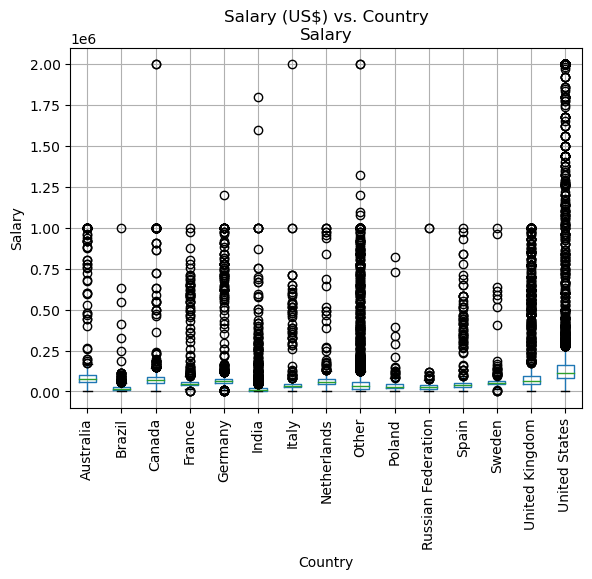

In [105]:
plt.figure(figsize=(12, 7))
df.boxplot(column='Salary', by='Country')
plt.suptitle('Salary (US$) vs. Country')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [106]:
df = df[df["Salary"] <= 250000]
df = df[df["Salary"] >= 10000]
df = df[df['Country'] != 'Other']

<Figure size 1200x700 with 0 Axes>

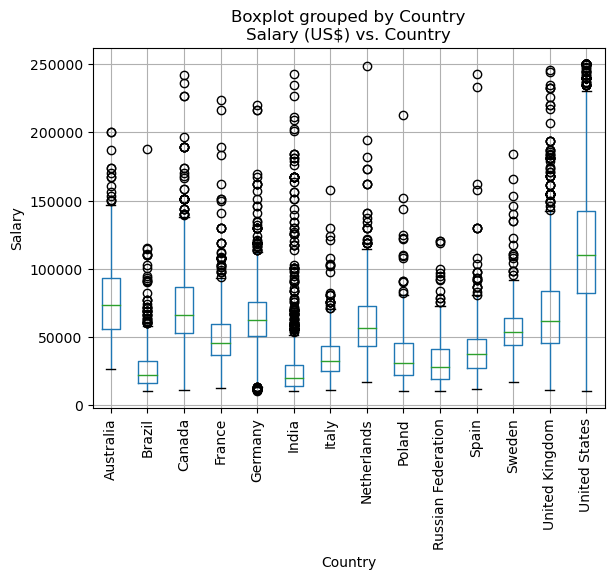

In [107]:
plt.figure(figsize=(12, 7))
df.boxplot(column='Salary', by='Country')
plt.title('Salary (US$) vs. Country')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [108]:
df["YearsCodePro"].unique()

array(['13', '4', '2', '7', '20', '1', '3', '10', '12', '29', '6', '28',
       '8', '23', '15', '25', '9', '11', 'Less than 1 year', '5', '21',
       '16', '18', '14', '32', '19', '22', '38', '30', '26', '27', '17',
       '24', '34', '35', '33', '36', '40', '39', 'More than 50 years',
       '31', '37', '41', '45', '42', '44', '43', '50', '49'], dtype=object)

In [109]:
def clean_experience(x):
    if x == 'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df['YearsCodePro'] = df['YearsCodePro'].apply(clean_experience)


In [110]:
df["YearsCodePro"].unique()

array([13. ,  4. ,  2. ,  7. , 20. ,  1. ,  3. , 10. , 12. , 29. ,  6. ,
       28. ,  8. , 23. , 15. , 25. ,  9. , 11. ,  0.5,  5. , 21. , 16. ,
       18. , 14. , 32. , 19. , 22. , 38. , 30. , 26. , 27. , 17. , 24. ,
       34. , 35. , 33. , 36. , 40. , 39. , 50. , 31. , 37. , 41. , 45. ,
       42. , 44. , 43. , 49. ])

In [111]:
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'I never completed any formal education',
       'Primary/elementary school'], dtype=object)

In [112]:
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)


In [113]:
df["EdLevel"].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

In [114]:
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df["EdLevel"].unique()

array([0, 2, 1, 3])

In [115]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df["Country"].unique()

array([13, 12, 10,  7,  4,  2,  6,  1,  3,  5, 11,  8,  0,  9])

In [116]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

In [117]:

lr = LinearRegression()
lr.fit(X, y.values)

LinearRegression()

In [118]:
y_pred = lr.predict(X)

In [119]:
error = np.sqrt(mean_squared_error(y, y_pred))

In [120]:
error

39274.75368318509

In [121]:
dtree = DecisionTreeRegressor(random_state=0)
dtree.fit(X, y.values)

DecisionTreeRegressor(random_state=0)

In [122]:
y_pred = dtree.predict(X)

In [123]:
error = np.sqrt(mean_squared_error(y, y_pred))
formatted_error = "${:,.2f}".format(error)
print(formatted_error)


$29,414.94


In [124]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X, y.values)

RandomForestRegressor(random_state=0)

In [125]:
y_pred = rf.predict(X)

In [126]:
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$29,487.31


In [127]:
# Define a list of possible values for the 'max_depth' hyperparameter
max_depth_values = [None, 2, 4, 6, 8, 10, 12]

# Create a dictionary containing the hyperparameters and their possible values
param_grid = {"max_depth": max_depth_values}

# Initialize the DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

# Create a GridSearchCV object for hyperparameter tuning
gs = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
gs.fit(X, y.values)


GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

In [128]:
# Get the best estimator from the GridSearchCV results
best_regressor = gs.best_estimator_

# Fit the best regressor to the data
best_regressor.fit(X, y.values)

# Predict the target values using the best regressor
y_pred = best_regressor.predict(X)

# Calculate the root mean squared error between true and predicted values
error = np.sqrt(mean_squared_error(y, y_pred))

# Print the error in a formatted monetary representation
print("${:,.02f}".format(error))


$30,428.51


In [129]:
X

,Country,EdLevel,YearsCodePro
7,13,0,13.0
9,12,2,4.0
10,12,0,2.0
11,10,1,7.0
12,7,1,20.0
...,...,...,...
64113,13,1,15.0
64116,13,0,6.0
64122,13,1,4.0
64127,13,3,12.0


In [130]:
# country, edlevel, yearscode
X = np.array([["United States", 'Master’s degree', 15 ]])
X

array([['United States', 'Master’s degree', '15']], dtype='<U15')

In [131]:
# Transform categorical features using LabelEncoder
X[:, 0] = le_country.fit_transform(X[:, 0])  # Transform country feature
X[:, 1] = le_education.fit_transform(X[:, 1])  # Transform education feature

# Convert X to float data type
X = X.astype(float)

# Display the transformed X
X


array([[ 0.,  0., 15.]])

In [132]:
y_pred = best_regressor.predict(X)
y_pred

array([91829.98255814])

In [133]:

data = {"model": best_regressor, "le_country": le_country, "le_education": le_education}

# Save the data to a file
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)


In [134]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]
le_country = data["le_country"]
le_education = data["le_education"]

In [135]:
y_pred = regressor_loaded.predict(X)
y_pred

array([91829.98255814])